# **1. Multi-class Weather Dataset**
[Multi-class Weather Dataset](https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset)은 다양한 기상 조건을 포함하는 이미지 데이터셋으로, 주로 기계 학습 및 딥러닝 모델을 학습하거나 평가하는 데 사용됩니다. 이 데이터셋은 맑음, 비, 눈, 흐림과 같은 여러 날씨 유형으로 라벨이 지정된 다중 클래스 분류 문제를 다룹니다. 각 클래스는 다양한 시간대, 계절, 지역에서 촬영된 이미지를 포함하여 현실 세계의 다양성을 반영하도록 설계되었습니다. 이를 통해 모델은 날씨 조건을 정확히 분류하고, 기상 관측, 자동화된 날씨 보고, 혹은 자율주행 차량의 환경 인식 시스템과 같은 다양한 응용 분야에서 활용될 수 있습니다.

In [1]:
from google.colab import files
files.upload()  # kaggle.json 업로드 창 표시
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download pratik2901/multiclass-weather-dataset

Dataset URL: https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/91.4M [00:00<?, ?B/s]
100% 91.4M/91.4M [00:00<00:00, 1.42GB/s]


In [3]:
import os
import zipfile
import random
from shutil import copyfile, rmtree  # 파일 관련 복사, 파일의 삭제 등을 하기 위한 모듈

zip_file = 'multiclass-weather-dataset.zip'
train_dir = './train'
test_dir = './test'

In [4]:
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('.')  # 현재위치에 압축풀기

In [5]:
# 분류 디렉터리 목록
categories = ['Cloudy', 'Rain', 'Shine', 'Sunrise']

In [6]:
if os.path.exists(train_dir):
    rmtree(train_dir)
if os.path.exists(test_dir):
    rmtree(test_dir)

# rmtree 해당 하위 폴더도 모두 삭제

In [7]:
# train, test 폴더 및 하위 카테고리 폴더 생성
os.makedirs(train_dir, exist_ok=True)  # exist_ok = True있으면 냅둬라
os.makedirs(test_dir, exist_ok=True)

In [8]:
for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

In [9]:
base_dir = '/content/Multi-class Weather Dataset'

In [10]:
# 각 카테고리별 데이터 파일 나누기
for category in categories:
    category_path = os.path.join(base_dir, category)
    files = os.listdir(category_path)
    # 베이스 디렉토리의 각각의 카테고리를 돌면서 그 안에 들어있는 파일들을 모두 리스트로 가져와라.
    # print(files)
    random.shuffle(files)

    # print(len(files))
    split_idx = int(len(files)*.8)   # trainData: 80%, testData: 20%
    # print(split_idx)
    train_files = files[:split_idx]
    test_files = files[split_idx:]

    for file in train_files:
        src = os.path.join(category_path, file)
        dst = os.path.join(train_dir, category, file)
        copyfile(src, dst) # src에서 dst로 복사

    for file in test_files:
        src = os.path.join(category_path, file)
        dst = os.path.join(test_dir, category, file)
        copyfile(src, dst)

print("데이터 분리가 완료되었습니다.")


데이터 분리가 완료되었습니다.


start

In [11]:
import torch
import time
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torchvision.utils import make_grid
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np

In [12]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(), # 랜덤으로 좌우반전. 확률 50%
    transforms.ToTensor(),
    # 텐서로 변환. 픽셀 값을 0~1 사이로 정규화 시킴.
    # RGB 이미지 : (H, W, C)
    # 변환 후 Tensor : (C, H, W)
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
        # [0.0 ~ 1.0] -> [-1.0 ~ 1.0] : 범위를 넓혀서 렐루를 사용할 때 특징을 더 잘 찾을 수 있다. (기울기를 살릴 수 있다.)
        # (weight) x = [0.2, 0.4, 0.7, 0.9] 렐루 통과 ->  [0.2, 0.4, 0.7, 0.9]
        # x = [-0.8, -0.2, 0.3, 0.9] 렐루 통과 -> [0.0, 0.0, 0.3, 0.9]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(), # 정규화
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [13]:
train_dataset = datasets.ImageFolder(
    root = 'train/',
    transform = transform_train
)

In [14]:
dataset_size = len(train_dataset)
# dataset_size
train_size = int(dataset_size*0.8)
val_size = dataset_size - train_size
print(train_size, val_size)

719 180


In [15]:
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [16]:
len(train_dataset), len(val_dataset)

(719, 180)

In [17]:
test_dataset = datasets.ImageFolder(
    root = 'test/',
    transform = transform_test
)

In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

**※ transforms.ToTensor()**

- 이미지를 PyTorch 텐서(tensor)로 변환합니다.
- 이미지의 픽셀 값을 [0, 255] 범위에서 [0.0, 1.0] 범위로 정규화합니다.
- 이미지의 차원을 (H, W, C) 형식에서 PyTorch에서 사용하는 (C, H, W) 형식으로 바꿉니다.
    - H: 이미지의 높이 (Height)
    - W: 이미지의 너비 (Width)
    - C: 채널(Channel; 예: RGB 이미지의 경우 3)


**※ transforms.Normalize(mean, std)**

- 텐서로 변환된 이미지의 픽셀 값을 정규화(normalization)합니다.
- mean: 각 채널(R, G, B)의 평균값.
- std: 각 채널의 표준편차.
- mean=[0.5, 0.5, 0.5]: R, G, B 채널 각각의 평균을 0.5로 설정.
- std=[0.5, 0.5, 0.5]: R, G, B 채널 각각의 표준편차를 0.5로 설정.
- 이 정규화는 일반적으로 픽셀 값의 범위를 [−1,1][-1, 1][−1,1]로 조정하기 위해 사용됩니다. (픽셀 값이 [0,1][0, 1][0,1]로 변환된 상태에서)

> 렐루에서 조금 더 좋은 결과를 보인다.


**※ ImageFolder**

- datasets.ImageFolder는 이미지 데이터를 특정 디렉터리 구조에서 로드하는 클래스입니다.
- 디렉터리 이름을 레이블(class label)로 간주하며, 각 디렉터리 내의 이미지 파일들을 해당 레이블에 할당합니다.
- 이 클래스는 이미지 데이터를 PyTorch 데이터셋(Dataset) 형식으로 변환하므로, DataLoader와 함께 사용하여 배치 처리 및 데이터 증강(data augmentation)을 쉽게 적용할 수 있습니다.

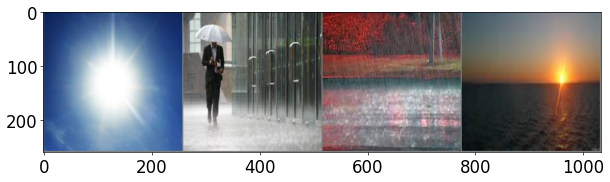

['Shine', 'Rain', 'Rain', 'Sunrise']


In [19]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

def imshow(input):
    input = input.numpy().transpose((1, 2, 0))   # torch.Tensor => numpy
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean # 정규화 해제 (역정규화) (연습용)
    input = np.clip(input, 0, 1) # 값이 0보다 작은 경우 0, 1보다 큰 경우 1로 변환합니다.
    plt.imshow(input)
    plt.show()

class_names = {
    0:"Cloudy", 1:"Rain", 2:"Shine", 3:"Sunrise"
}

iterator = iter(train_dataloader)
imgs, labels = next(iterator)
out = make_grid(imgs[:4]) # 여러 이미지(0 ~ 3)를 하나의 격자 형태로 합침
imshow(out)

print([class_names[labels[i].item()] for i in range(4)])

# **2. 다양한 모델 만들기**

In [20]:
# 단일 선형 계층
# 활성화 함수나 추가 계층이 없으므로 모델이 표현할 수 있는 함수는 단순 선형 변환에 제한
# (256*256*3+1)*4 = 786,436
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.linear1 = nn.Linear(256 * 256 * 3, 4)  # 256x256x3 이미지 → Cloudy, Rain, Shine, Sunrise 4개 클래스 분류
        self.flatten = nn.Flatten()  # 이미지를 1차원 벡터로 변환

    def forward(self, x):  # 순전파 정의 (입력 → 예측값 반환)
        x = self.flatten(x)
        x = self.linear1(x)
        return x

In [21]:
# 두 개의 선형 계층을 사용하여 입력 데이터를 단계적으로 압축
# (256*256*3+1)*64 + (64+1)*4 = 12,583,236
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.linear1 = nn.Linear(256 * 256 * 3, 64)
        self.linear2 = nn.Linear(64, 4)  # 은닉층 출력을 4개의 클래스 점수(logits)로 변환
        self.flatten = nn.Flatten()

    def forward(self, x): # x: 이미지
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [22]:
# 다중 구조와 ReLU 활성화 함수를 사용하여 비선형적 특징을 학습할 수 있음
# Dropout을 통해 과적합을 방지
# (256*256*3+1)*128 + (128+1)*64 + (64+1)*32 + (32+1)*4 = 25176420
class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        self.linear1 = nn.Linear(256 * 256 * 3, 128)  # 노드가 128개
        self.dropout1 = nn.Dropout(0.5)  # 50% 확률(랜덤)로 기울기를 0으로 만들어서 64개만 학습. (과적합 방지)
        self.linear2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(0.5)
        self.linear4 = nn.Linear(32, 4)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.linear1(x))  # 활성화함수로 씌움.
        x = self.dropout1(x)
        x = F.relu(self.linear2(x))
        x = self.dropout2(x)
        x = F.relu(self.linear3(x))
        x = self.dropout3(x)
        x = self.linear4(x)
        return x



**※ nn.Module 상속**

1. 모델 구성 요소 관리: 레이어와 파라미터를 자동으로 관리.
2. 순전파(Forward) 정의: forward() 메서드를 통해 간단하고 일관된 순전파 과정 정의.
3. 계층적 설계: 서브모듈을 활용해 복잡한 모델을 쉽게 설계.
4. 유틸리티 제공: 파라미터 저장/로드, 학습/추론 모드 전환 등 다양한 기능 제공.
5. PyTorch 호환성: 최적화, 데이터 로더 등 PyTorch의 다른 기능과 손쉽게 통합.
6. 추상화: 저수준 작업을 추상화하여 개발자의 생산성을 향상.

**※ Dropout**

nn.Dropout()은 PyTorch에서 제공하는 과적합(overfitting)을 방지하기 위한 레이어입니다. 드롭아웃은 학습 과정 중 일부 뉴런을 무작위로 "비활성화(drop)"함으로써, 모델이 특정 뉴런에 지나치게 의존하지 않도록 도와줍니다. 이를 통해 모델의 일반화 성능이 향상됩니다.

In [23]:
def train():
    start_time = time.time()
    print(f'[Epoch: {epoch+1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(train_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i  % log_step == 0:
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

In [24]:
def validate():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Validation]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(val_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i % log_step == 0:
            print(f'[Batch: {i + 1}] running val loss: {running_loss / total}, running val accuracy: {running_corrects / total}')

    print(f'val loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

In [25]:
def test():
    start_time = time.time()
    print(f'[Test]')
    model.eval()  # 테스트모드로 돌린다.
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():  # 학습모드가 아닌 테스트모드.
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i % log_step == 0:
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()


In [26]:
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 3:
        lr /= 10
    if epoch >= 7:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

## Model1

In [27]:
learning_rate = 0.01
log_step = 8

model = Model1()
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []

os.makedirs("weights/Model1", exist_ok=True)

for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f"weights/Model1/best_checkpoint_epoch_{epoch + 1}.pth")

torch.save(model.state_dict(), f"weights/Model1/last_checkpoint_epoch_{num_epochs}.pth")

[Epoch: 1 - Training]
[Batch: 1] running train loss: 0.02373424544930458, running train accuracy: 0.1875
[Batch: 9] running train loss: 0.25340229148666066, running train accuracy: 0.5763888955116272
train loss: 0.27152384736773366, accuracy: 0.6050069332122803
elapsed time: 5.441829681396484
[Epoch: 1 - Validation]
[Batch: 1] running val loss: 0.3563605844974518, running val accuracy: 0.609375
val loss: 0.42552687327067057, accuracy: 0.6111111044883728
elapsed time: 1.7742547988891602
[Info] best validation accuracy!
[Epoch: 2 - Training]
[Batch: 1] running train loss: 0.4143272042274475, running train accuracy: 0.6875
[Batch: 9] running train loss: 0.28711434702078503, running train accuracy: 0.7152777910232544
train loss: 0.3474010141237389, accuracy: 0.7009735703468323
elapsed time: 4.6509318351745605
[Epoch: 2 - Validation]
[Batch: 1] running val loss: 0.26229801774024963, running val accuracy: 0.78125
val loss: 0.29577778710259334, accuracy: 0.7555555701255798
elapsed time: 1.238

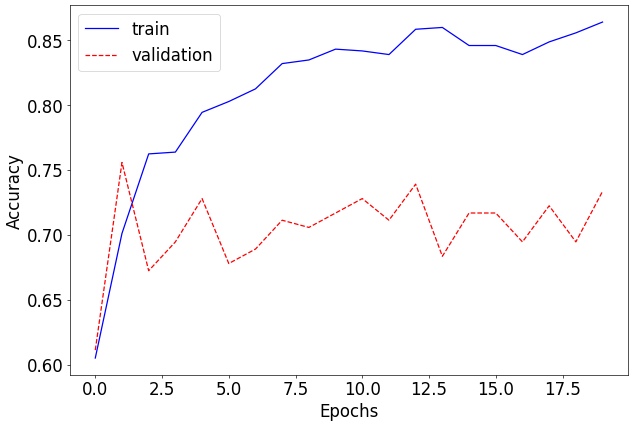

In [28]:
plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [29]:
test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

[Test]
[Batch: 1] running test loss: 0.27705609798431396, running test accuracy: 0.53125
test loss: 0.20044377630790777, accuracy: 0.721238911151886
elapsed time: 2.2658181190490723
Test loss: 0.20044378
Test accuracy: 72.12%


## Model2

In [30]:
os.makedirs("weights/Model2", exist_ok=True)

learning_rate = 0.01
log_step = 8

model = Model2()
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f"weights/Model2/best_checkpoint_epoch_{epoch + 1}.pth")

torch.save(model.state_dict(), f"weights/Model2/last_checkpoint_epoch_{num_epochs}.pth")

[Epoch: 1 - Training]
[Batch: 1] running train loss: 0.02122759446501732, running train accuracy: 0.3125
[Batch: 9] running train loss: 0.0944880640341176, running train accuracy: 0.5277777910232544
train loss: 0.12363132846869414, accuracy: 0.5299026370048523
elapsed time: 4.660942792892456
[Epoch: 1 - Validation]
[Batch: 1] running val loss: 0.15623092651367188, running val accuracy: 0.453125
val loss: 0.19272845056321886, accuracy: 0.4055555760860443
elapsed time: 1.2612063884735107
[Info] best validation accuracy!
[Epoch: 2 - Training]
[Batch: 1] running train loss: 0.1762188971042633, running train accuracy: 0.390625
[Batch: 9] running train loss: 0.3770670062965817, running train accuracy: 0.4809027910232544
train loss: 0.5030203993031975, accuracy: 0.5076495409011841
elapsed time: 5.197549104690552
[Epoch: 2 - Validation]
[Batch: 1] running val loss: 0.3735584318637848, running val accuracy: 0.609375
val loss: 0.39808674918280706, accuracy: 0.5666666626930237
elapsed time: 1.460

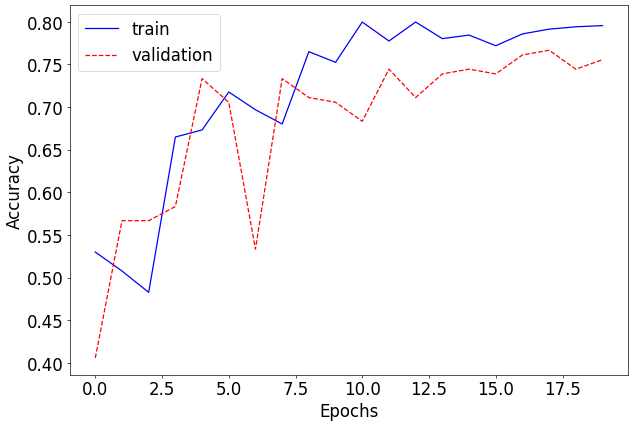

In [31]:
plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [32]:
test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

[Test]
[Batch: 1] running test loss: 0.017148533836007118, running test accuracy: 0.71875
test loss: 0.017220181965194974, accuracy: 0.7964601516723633
elapsed time: 1.4963181018829346
Test loss: 0.01722018
Test accuracy: 79.65%


## Model3

In [33]:
os.makedirs("weights/Model3", exist_ok=True)

learning_rate = 0.01
log_step = 20

model = Model3()
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []

for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f"weights/Model3/best_checkpoint_epoch_{epoch + 1}.pth")

torch.save(model.state_dict(), f"weights/Model3/last_checkpoint_epoch_{num_epochs}.pth")

[Epoch: 1 - Training]
[Batch: 1] running train loss: 0.02214483916759491, running train accuracy: 0.28125
train loss: 0.02112151701029219, accuracy: 0.4102920889854431
elapsed time: 4.731800079345703
[Epoch: 1 - Validation]
[Batch: 1] running val loss: 0.015083098784089088, running val accuracy: 0.59375
val loss: 0.015385125411881341, accuracy: 0.5944444537162781
elapsed time: 1.2994060516357422
[Info] best validation accuracy!
[Epoch: 2 - Training]
[Batch: 1] running train loss: 0.01891937479376793, running train accuracy: 0.421875
train loss: 0.01664544022298821, accuracy: 0.5257301926612854
elapsed time: 5.039891242980957
[Epoch: 2 - Validation]
[Batch: 1] running val loss: 0.01329555083066225, running val accuracy: 0.6875
val loss: 0.012570034464200337, accuracy: 0.7333333492279053
elapsed time: 1.2081513404846191
[Info] best validation accuracy!
[Epoch: 3 - Training]
[Batch: 1] running train loss: 0.015651855617761612, running train accuracy: 0.53125
train loss: 0.0157479838635228

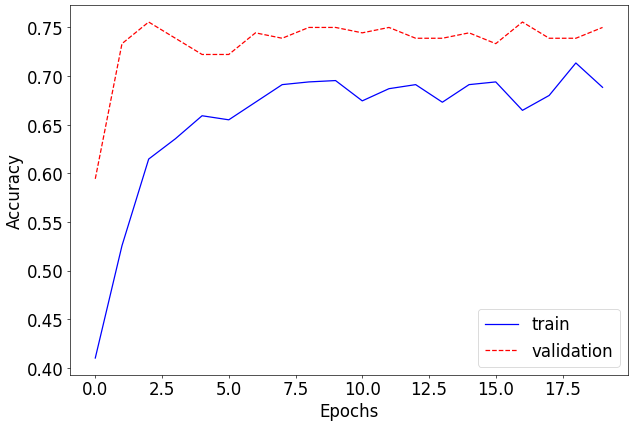

In [34]:
plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [35]:
test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

[Test]
[Batch: 1] running test loss: 0.016300631687045097, running test accuracy: 0.546875
test loss: 0.011427759728600493, accuracy: 0.73893803358078
elapsed time: 1.5478341579437256
Test loss: 0.01142776
Test accuracy: 73.89%
